In [2]:
import jax
import jax.numpy as jnp                # JAX NumPy

from flax import linen as nn           # The Linen API
from flax import traverse_util
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np                     # Ordinary NumPy
import optax                           # Optimizers
import matplotlib.pyplot as plt
import networkx as nx

def init_board():
  return np.zeros((3, 3), dtype=int).flatten()

def flip_board(board):
  return -board

def get_valid_mask(board):
  return board == 0

# #Always assume action is made by player 1
# def get_next_state(board, action):
#   return board.flatten().at[action].add(1).reshape(board.shape)

#Always assume action is made by player 1
#Assume action is valid
def get_next_state(board, action):
  if(board[action] == 1 or board[action] == -1):
    print("Illegal Move")
    print(board.reshape((3,3)))
    print(action)
    print(get_reward(board))
    assert False
  next_board = board.copy()
  next_board[action] = 1
  return next_board

def sample_action(action_dist):
  action_dist = action_dist.flatten() / action_dist.sum()
  return np.random.choice(action_dist.shape[0], p=action_dist)

def disp_board(board):
  plt.imshow(board)

reward_conv = nn.Conv(features=4, kernel_size=(3, 3), use_bias=False, padding='SAME')
stripe_filter = jnp.array([[0, 0, 0], [1, 1, 1], [0, 0, 0]])
reward_kernel = jnp.expand_dims(jnp.stack([jnp.eye(3), jnp.eye(3)[::-1, :], stripe_filter, stripe_filter.T], axis=2), 2)

reward_conv_param = {'params': {'kernel': reward_kernel}}
# print(jnp.expand_dims(jnp.eye(4), (0, 3)))

def get_reward(board):
    board_score = reward_conv.apply(reward_conv_param, jnp.expand_dims(jnp.array(board).reshape((3, 3)), (0, 3)))
    # print(jnp.transpose(board_score[0]))
    is_win = (jnp.max(board_score) >= 3).astype(int)
    is_loss = (jnp.min(board_score) <= -3).astype(int)
    score = float(is_win - is_loss)
    return score, (is_win >= 1 or is_loss >= 1 or ((board == 0).sum() == 0))

In [3]:
diag_mask = np.eye(3)
ld_mask = np.eye(3)[::-1, :]
def get_reward(board): #Assume move and flip, so board can only be lost
    b = board.reshape((3,3))
    diag = np.sum(diag_mask*b) <= -3
    diag_l = np.sum(ld_mask*b) <= -3
    row = np.min(b@np.ones(3)) <= -3
    col = np.min(b.T@np.ones(3)) <= -3
    reward = -int(diag or diag_l or row or col)
    return reward, (reward != 0 or (board == 0).sum() == 0)


In [4]:

# rng = jax.random.PRNGKey(40)
for i in range(200):
  board = init_board()
  for i in range(10):
    # _, rng = jax.random.split(rng, 2)
    action_dist = np.ones(board.shape) * get_valid_mask(board)
    next_action = sample_action(action_dist)
    # print(board.reshape((3,3)), next_action)
    board = flip_board(get_next_state(board, next_action))
    reward, game_over = get_reward(board)
    if(game_over):
      break
print(board.reshape((3, 3)), reward, game_over)

[[ 1 -1 -1]
 [ 1 -1  1]
 [-1  0  1]] -1 True


In [5]:
def toy_model(state):
    return np.ones(state.shape) / state.shape[0], 0.1

[[ 1 -1  1]
 [-1  0  0]
 [-1  0  0]]
[[ 1. -1.  1.]
 [-1.  0.  0.]
 [-1.  0.  0.]]
[[ 0.          0.          0.        ]
 [ 0.          0.08076923  0.07692308]
 [ 0.         -0.21578947  0.88344988]]
25


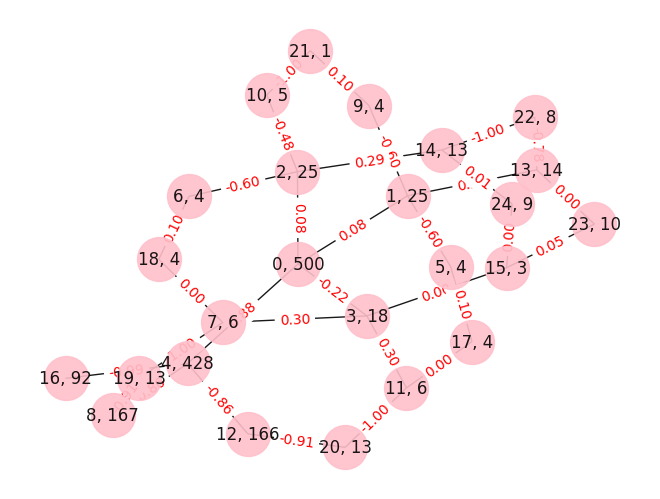

In [103]:

STATE_DIM = 9 #Dimension of 4x4 tic-tac-toe board
ACTION_DIM = 9
MAX_SIZE = int(1e3)
C_BASE, C_INIT = 1.0, 1.0
class MCTS:
    def __init__(self, max_size=MAX_SIZE):
        self.state = np.zeros((max_size, STATE_DIM))
        self.state_lookup = {} #Maps state representation to index
        self.expanded = []

        self.visit_count = np.zeros(max_size)
        self.action_visits  = np.zeros((max_size, ACTION_DIM), dtype=int)
        self.action_total_value = np.zeros((max_size, ACTION_DIM))
        self.action_mean_value = np.zeros((max_size, ACTION_DIM))
        self.action_prior = np.zeros((max_size, ACTION_DIM))
        # self.action_children = np.zeros((MAX_SIZE, ACTION_DIM), dtype=int) - 1
    
    #Assumes state is already expanded, and uses MCTS info to pick best action
    def select_action(self, state, state_index):
        state_visits = self.visit_count[state_index]
        # exp_rate = np.log((1+state_visits + C_BASE)/C_BASE) + C_INIT
        exp_rate = 2
        model_prior = self.action_prior[state_index]
        sa_visits = self.action_visits[state_index]
        sa_mean_value = (1+self.action_mean_value[state_index])/2 #Normalize to [0, 1]
        # print(state_index, sa_mean_value)
        action_distr = (sa_mean_value + exp_rate*np.sqrt(state_visits)*model_prior/(1+sa_visits))*get_valid_mask(state)
        # print("action distr", action_distr)
        action = np.argmax(action_distr)
        # print(state[action])
        if(state[action] != 0):
            print("State", state.reshape((3,3)))
            print("action", action)
            print("exp rate", exp_rate)
            print("sa mean value", sa_mean_value, sa_visits)
            print("action distr", action_distr)
            print("model prior", model_prior)
            print("action_mask", get_valid_mask(state))
        return action

    def get_action_prob(self, state_index, temperature=1):
        """
        Select action according to the visit count distribution and the temperature.
        """
        action_visits = self.action_visits[state_index]
        if temperature == 0:
            a = np.argmax(action_visits)
            r = np.zeros(action_visits.shape)
            r[a] = 1.0
            return r
        elif temperature == float("inf"):
            return np.ones(action_visits.shape)/action_visits.shape[0]
        else:
            # See paper appendix Data Generation
            visit_count_distribution = np.power(action_visits, 1 / temperature)
            visit_count_distribution = visit_count_distribution / sum(visit_count_distribution)
            return visit_count_distribution
            
    def expand_node(self, state, action_probs):
        state_index = len(self.expanded)
        # print("state index", state_index)
        self.expanded.append(True)
        self.state_lookup[state.tobytes()] = state_index

        self.state[state_index] = state
        self.visit_count[state_index] += 1
        # print(self.action_prior[state_index].shape, action_probs.shape)
        valid_moves = get_valid_mask(state)
        action_probs = (action_probs + 1e-6) * valid_moves  # mask invalid moves
        action_probs /= np.sum(action_probs)
        self.action_prior[state_index] = action_probs
        return state_index

    def search_iter(self, state_index, model):
        search_path = []
        path_actions = []

        curr_index = state_index
        curr_state = self.state[state_index]

        # Loop until reaching an untracked state
        while curr_index >= 0:
            search_path.append(curr_index)
            action = self.select_action(curr_state, curr_index)
            path_actions.append(action)
            curr_state = flip_board(get_next_state(curr_state, action))
            nsr = curr_state.tobytes()
            if(nsr in self.state_lookup):
                curr_index = self.state_lookup[nsr]
            else:
                curr_index = -1

        # The value of the new state from the perspective of the other player
        next_state = curr_state
        value, game_over = get_reward(next_state)
        value = -value
        if not game_over:
            # If the game has not ended:
            # EXPAND
            action_probs, value = model(next_state)
            valid_moves = get_valid_mask(next_state)
            action_probs = action_probs * valid_moves  # mask invalid moves
            action_probs /= np.sum(action_probs)
            self.expand_node(next_state, action_probs)
        
        #Backpropagate MCTS search path
        for i in range(len(search_path)-1, -1, -1):
            si, a = search_path[i], path_actions[i]
            self.visit_count[si] += 1
            self.action_visits[si, a] += 1
            self.action_total_value[si, a] += value
            self.action_mean_value[si, a] = self.action_total_value[si, a] / self.action_visits[si, a]
            value *= -1

        # print("search path", search_path)
        # print("search visits after update", [self.visit_count[s] for s in search_path])
        
    def mcts_eval(self, state, model, num_sims):
        # print("Expanded len", len(self.expanded))
        root_state = state
        action_prior, value_est = model(root_state)
        root_index = self.expand_node(root_state, action_prior)
        # print("Root index", root_index)
        for _ in range(num_sims):
            self.search_iter(root_index, model)
        return root_index
    
    def print_tree(self, root_index=0):
        for state_index in self.state_lookup.values():
            state = self.state[state_index]
            print(state.reshape((3, 3)))
            visited_actions = self.action_visits[state_index].nonzero()[0]
            action_values = self.action_mean_value[state_index, visited_actions]
            print("Action", visited_actions)
            print("Action value", action_values)

    def visualize_tree(self):
        G = nx.Graph()
        node_labels = {}
        edge_labels = {}
        for state_index in self.state_lookup.values():
            visited_actions = self.action_visits[state_index].nonzero()[0]
            action_values = self.action_mean_value[state_index, visited_actions]
            state = self.state[state_index]
            for action, value in zip(visited_actions, action_values):
                child_state = flip_board(get_next_state(state, action))
                # print(child_state.reshape((3,3)))
                if(child_state.tobytes() in self.state_lookup):
                    child_index = self.state_lookup[child_state.tobytes()]
                    G.add_edge(state_index, child_index)
                    edge_labels[(state_index, child_index)] = f'{value:.2f}'
            node_labels[state_index] = f"{state_index}, {self.action_visits[state_index].sum()}" 
        
        pos = nx.spring_layout(G, scale=2.5)

        plt.figure()
        nx.draw(
            G, pos, edge_color='black', width=1, linewidths=1, node_size=1000, 
            node_color='pink', alpha=0.9,
            labels=node_labels
        )
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edge_labels,
            font_color='red'
        )
        plt.axis('off')
        plt.show()

    def visualize_tree_detailed(self):
        G = nx.Graph()
        node_labels = {}
        edge_labels = {}
        for state_index in self.state_lookup.values():
            visited_actions = self.action_visits[state_index].nonzero()[0]
            action_values = self.action_mean_value[state_index, visited_actions]
            state = self.state[state_index]
            for action, value in zip(visited_actions, action_values):
                child_state = flip_board(get_next_state(state, action))
                # print(child_state.reshape((3,3)))
                if(child_state.tobytes() in self.state_lookup):
                    child_index = self.state_lookup[child_state.tobytes()]
                    G.add_edge(state_index, child_index)
                    edge_labels[(state_index, child_index)] = f'{value:.2f}'
            node_labels[state_index] = f"{state_index}, {self.action_visits[state_index].sum()}" 
        
        pos = nx.spring_layout(G)
        plt.figure()
        nx.draw(
            G, pos, edge_color='black', width=1, linewidths=1, node_size=1000, 
            node_color='pink', alpha=0.9,
            labels=node_labels
        )
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edge_labels,
            font_color='red'
        )
        plt.axis('off')
        plt.show()

# root_state = np.array([-1, 1, 0, 0, 0, 0, -1, 1, 0])
# print(root_state.reshape((3, 3)))
# root_state[:2] = 1
# root_state = np.zeros(9)
# mcts = MCTS(max_size=5000)
# mcts.mcts_eval(root_state, toy_model, 5000)
# print("Finished mcts")
# mcts.visualize_tree()

root_state = np.array([1, -1,  1, -1, 0,  0, -1,  0, 0])
print(root_state.reshape((3,3)))
mcts = MCTS(max_size=5000)
mcts.mcts_eval(root_state, toy_model, 500)

print(mcts.state[0].reshape((3,3)))
print(mcts.action_mean_value[0].reshape((3,3)))
print(len(mcts.expanded))
mcts.visualize_tree()

[(0.0, -0.3)]
[(0.0, -0.6), (0.44999999999999996, -0.6), (0.8999999999999999, -0.6), (1.3499999999999999, -0.6)]
[(0.0, -0.7666666666666666), (0.25, -0.7666666666666666), (0.5, -0.7666666666666666), (0.75, -0.7666666666666666), (1.0, -0.7666666666666666), (1.25, -0.7666666666666666), (1.5, -0.7666666666666666), (1.75, -0.7666666666666666), (2.0, -0.7666666666666666), (2.25, -0.7666666666666666), (2.5, -0.7666666666666666), (2.75, -0.7666666666666666)]
[(0.0, -0.9333333333333332), (0.25, -0.9333333333333332), (0.5, -0.9333333333333332), (0.75, -0.9333333333333332), (1.0, -0.9333333333333332), (1.25, -0.9333333333333332), (1.5, -0.9333333333333332), (1.75, -0.9333333333333332), (2.0, -0.9333333333333332), (2.25, -0.9333333333333332), (2.5, -0.9333333333333332), (2.75, -0.9333333333333332)]


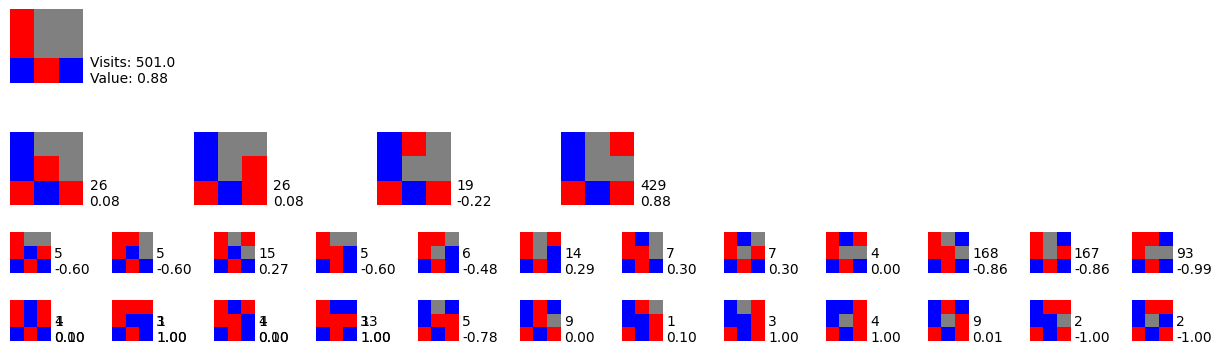

In [158]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from matplotlib.collections import LineCollection

data = board.reshape((3,3))

# create discrete colormap
cmap = colors.ListedColormap(['red', 'grey', 'blue'])
bounds = [-2, -0.5, 0.5, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)

# ax.imshow(data, cmap=cmap, norm=norm)

def draw_layer(ax, to_print, layer_level, spacing):
    #draw layer
    gx = np.linspace(0, 0.6, 4)
    draw_pos = []
    for i, t in enumerate(to_print):
        state, text = t
        state = state.reshape((3,3))
        ax.pcolormesh((gx+i*1.5)*spacing, gx*spacing-layer_level, state, shading='flat', cmap=cmap)
        draw_pos.append((i*1.5*spacing, -layer_level))
        ax.text((i*1.5+0.65)*spacing, -layer_level, text)
    return draw_pos

def plot_mcts(ax, mcts, root_index): 
    layer = [root_index]
    value, count = mcts.action_mean_value[root_index].max(), mcts.visit_count[root_index]
    to_print = [(mcts.state[root_index], f"Visits: {count}\nValue: {value:.2f}")]

    layer_row = 0
    layer_level = 0
    segments = []
    while len(layer) > 0:
        spacing = min(2 / len(to_print), 0.3)
        prev_layer_level, layer_level = layer_level, layer_level + spacing, 
        prev_draw_pos = draw_layer(ax, to_print, layer_level, spacing)
        print(prev_draw_pos)
       
        next_layer = []
        to_print = []
        seen_states = {}
        for parent_i, state_index in enumerate(layer):
            state = mcts.state[state_index]
            visited_actions, = np.nonzero(mcts.action_visits[state_index])
            visit_counts = mcts.action_visits[state_index][visited_actions]
            action_values = mcts.action_mean_value[state_index, visited_actions]
            for action, count, value in zip(visited_actions, visit_counts, action_values):
                child_state = flip_board(get_next_state(state, action))
                if(child_state.tobytes() in seen_states):
                    child_i = seen_states[child_state.tobytes()]
                    px, py = parent_i*1.5*spacing, -prev_layer_level
                    cx, cy = child_i*1.5*spacing, -layer_level
                    segments.append(((px, py), (cx, cy)))
                    continue

                if(child_state.tobytes() in mcts.state_lookup):
                    child_index = mcts.state_lookup[child_state.tobytes()]
                    next_layer.append(child_index)
                # if(layer_row % 2 == 0):
                #     child_state = flip_board(child_state)
                    # value *= -1
                
                seen_states[child_state.tobytes()] = len(to_print)
                child_i = len(to_print)
                px, py = parent_i*1.5*spacing, -layer_level
                cx, cy = child_i*1.5*spacing, -prev_layer_level
                # segments.append(((px, py), (cx, cy)))
                to_print.append((child_state, f"{count}\n{value:.2f}"))
        layer_row += 1
        layer = next_layer
    draw_layer(ax, to_print, layer_level, spacing)

fig, ax = plt.subplots(figsize=(15, 15))
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_frame_on(False)
ax.set_aspect('equal')
plot_mcts(ax, mcts, 0)
fig.show()

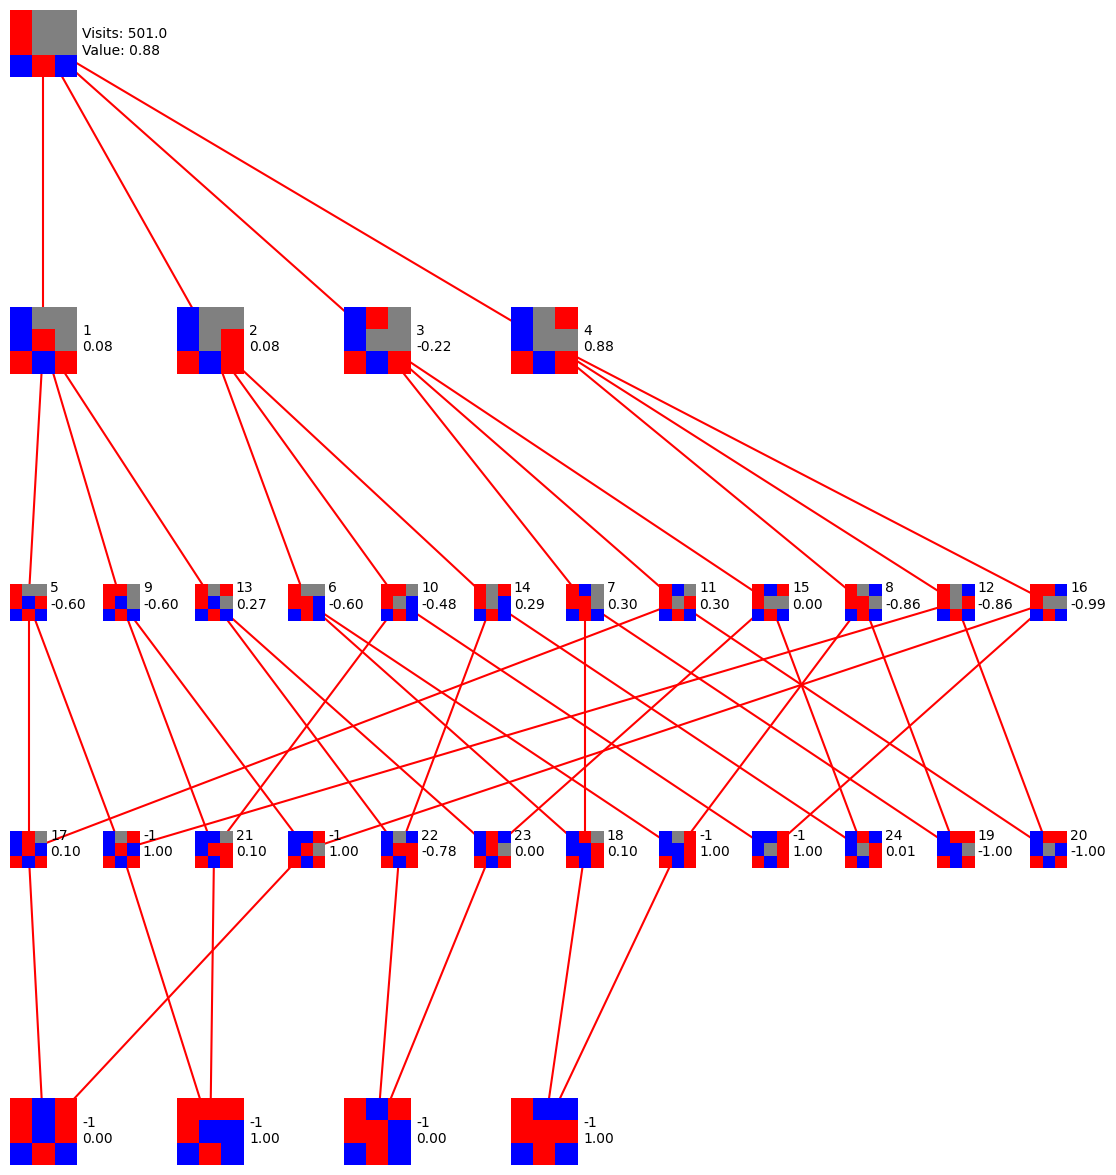

In [171]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from matplotlib.collections import LineCollection

data = board.reshape((3,3))

# create discrete colormap
cmap = colors.ListedColormap(['red', 'grey', 'blue'])
bounds = [-2, -0.5, 0.5, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)

def box_pos(num_box, layer_level, spacing, offset=0.0):
    offset = spacing*offset
    draw_pos = [(i*1.5*spacing+offset, -layer_level+offset) for i in range(num_box)]
    return draw_pos

def draw_edges(ax, dp1, dp2, edges):
    # print(edges)
    segments = []
    for p, c in edges:
        segments.append(((dp1[p], dp2[c])))
    # print("segments", segments)
    line_segments = LineCollection(segments, linestyles='solid', color='red', zorder=0)
    ax.add_collection(line_segments)

def draw_layer(ax, to_print, draw_pos, spacing):
    #draw layer
    gx = np.linspace(0, 0.6, 4)
    for pos, t in zip(draw_pos, to_print):
        x, y = pos
        state, text = t
        state = state.reshape((3,3))
        ax.pcolormesh(gx*spacing+x, gx*spacing+y, state, shading='flat', cmap=cmap)
        ax.text(x+0.65*spacing, y+0.2*spacing, text)


def plot_mcts(ax, mcts, root_index): 
    layer = [root_index]
    value, count = mcts.action_mean_value[root_index].max(), mcts.visit_count[root_index]
    to_print = [(mcts.state[root_index], f"Visits: {count}\nValue: {value:.2f}")]

    to_print_l = [to_print]
    edges_l = []

    layer_row = 0
    while len(layer) > 0:
        next_layer = []
        to_print = []
        edges = []
        state_index_map = {}
        for parent_i, state_index in enumerate(layer):
            state = mcts.state[state_index]
            visited_actions, = np.nonzero(mcts.action_visits[state_index])
            visit_counts = mcts.action_visits[state_index][visited_actions]
            action_values = mcts.action_mean_value[state_index, visited_actions]
            for action, count, value in zip(visited_actions, visit_counts, action_values):
                child_state = flip_board(get_next_state(state, action))

                # if(layer_row % 2 == 0):
                #     child_state = flip_board(child_state)
                #     value *= -1
                                
                if(child_state.tobytes() in state_index_map):
                    child_i = state_index_map[child_state.tobytes()]
                    edges.append((parent_i, child_i))
                    continue
                child_index = -1
                if(child_state.tobytes() in mcts.state_lookup):
                    child_index = mcts.state_lookup[child_state.tobytes()]
                    next_layer.append(child_index)
                
                child_i = len(to_print)
                edges.append((parent_i, child_i))
                state_index_map[child_state.tobytes()] = child_i
                to_print.append((child_state, f"{child_index}\n{value:.2f}"))
        
        to_print_l.append(to_print)
        edges_l.append(edges)
        layer_row += 1
        layer = next_layer
    
    spacing_l = np.array([min(0.3, 2/len(to_print)) for to_print in to_print_l])
    layer_level_l = np.cumsum(spacing_l+0.5)

    draw_pos = box_pos(len(to_print_l[0]), layer_level_l[0], spacing_l[0], offset=0.3)
    for i in range(1, len(to_print_l)):
        next_draw_pos = box_pos(len(to_print_l[i]), layer_level_l[i], spacing_l[i], offset=0.3)
        # print(len(draw_pos), len(next_draw_pos))
        draw_edges(ax, draw_pos, next_draw_pos, edges_l[i-1])
        draw_pos = next_draw_pos
    
    for i in range(len(to_print_l)):
        draw_pos = box_pos(len(to_print_l[i]), layer_level_l[i], spacing_l[i])
        draw_layer(ax, to_print_l[i], draw_pos, spacing_l[i])
    # draw_pos = box_pos(len(to_print), layer_level, spacing)

fig, ax = plt.subplots(figsize=(15, 15))
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_frame_on(False)
ax.set_aspect('equal')
plot_mcts(ax, mcts, 0)
fig.show()

In [168]:
print(mcts.state[23].reshape((3,3)))
print(flip_board(get_next_state(mcts.state[23], 5)).reshape((3,3)))

[[-1.  1. -1.]
 [ 1. -1. -0.]
 [ 1. -1.  1.]]
[[ 1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1. -1.]]


In [88]:
print(mcts.action_mean_value[0])

[ 0.          0.          0.          0.          0.1        -0.18333333
  0.         -0.1375      0.5       ]


In [251]:
def self_play_episode(model, num_sims=50, temp_threshold=6):
    train_examples = []
    board = init_board()
    step = 0
    while True:
        mcts = MCTS()
        root_index = mcts.mcts_eval(board, model, num_sims=num_sims)
        
        temp = int(step < temp_threshold)
        pi = mcts.get_action_prob(root_index, temperature=temp)

        train_examples.append((board, pi, step))

        action = np.random.choice(ACTION_DIM, p=pi)
        # print("action", action)
        
        board = flip_board(get_next_state(board, action))

        #Reward is always negative because board is flipped after move. 
        r, game_over = get_reward(board) 
        if(game_over):
            return [(b, p, (-1)**(step-s)) for b, p, s in train_examples]
        step += 1

def batch_examples(train_examples):
    state_batch = jnp.stack([t[0] for t in train_examples])
    pa_batch = jnp.stack([t[1] for t in train_examples])
    r_batch = jnp.stack([t[2] for t in train_examples]).reshape((-1, 1))
    return state_batch, pa_batch, r_batch

train_examples = self_play_episode(toy_model, num_sims=1000)
state_b, pa_b, r_b = batch_examples(train_examples)

In [252]:
from jax import jit

class TTTModel(nn.Module):
  """A simple MLP model."""
  @nn.compact
  def __call__(self, x):
    x = nn.Dense(features=64)(x)
    body = nn.Dense(features=32)(x)
    x = nn.Dense(features=9)(body)
    value = nn.tanh(nn.Dense(features=1)(body)) #Value estimate between -1 and 1
    return x, value

@jit
def model_agent(x, params):
  logits, value = TTTModel().apply(params, x)
  return nn.softmax(logits), value

model = TTTModel()
rng = jax.random.PRNGKey(42)
params = model.init(rng, board)
# model.apply(params, state_b)[1].shape
# model_agent(state_b, params)

In [253]:
def create_train_state(rng, learning_rate, momentum):
  """Creates initial `TrainState`."""
  model = TTTModel()
  params = model.init(rng, jnp.ones([1, 9]))['params']

  tx = optax.sgd(learning_rate, momentum)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, state_b, pa_b, r_b):
  """Train for a single step."""
  def loss_fn(params):
    logits, exp_value = TTTModel().apply({'params': params}, state_b)
    loss = optax.softmax_cross_entropy(logits, pa_b).mean() + jnp.square(r_b - exp_value).mean()
    return loss, (logits, exp_value)
  grad_fn = jax.grad(loss_fn, has_aux=True)
  grads, aux = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  # metrics = compute_metrics(logits=logits, labels=batch['label'])
  return state#, metrics

# state = train_step(state, state_b, pa_b, r_b)

In [254]:
state = create_train_state(rng, 0.01, 0.1)
for i in range(150):
    print(f"Batch {i}")
    train_examples = []
    for i in range(10):
        train_examples += self_play_episode(lambda x: model_agent(x, {'params': state.params}), num_sims=150)
    state_b, pa_b, r_b = batch_examples(train_examples)
    state = train_step(state, state_b, pa_b, r_b)

Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110


In [264]:
board = np.array([1, -1, 0, -1, 1, 0, -1, 0, -1])
# board = np.zeros_like(board)
print(board.reshape((3,3)))
model = TTTModel()
action_prior, value = model.apply({'params': state.params}, board)
print(action_prior.reshape((3,3)), value)

def learned_agent(board):
    prior = model_agent(board, {'params': state.params})[0]
    prior *= get_valid_mask(board)
    return np.argmax(prior)

def random_agent(board):
    valid_mask = np.float32(get_valid_mask(board))
    valid_mask /= valid_mask.sum()
    return np.random.choice(board.shape[0], p=valid_mask)

def mcts_agent(board):
    mcts = MCTS()
    root_index = mcts.mcts_eval(board, lambda x: model_agent(x, {'params': state.params}), num_sims=100)
    pi = mcts.get_action_prob(root_index, temperature=0)
    if(np.min(pi) < 0):
        print(board.reshape((3,3)))
        print(pi)
        assert False
    action = np.random.choice(ACTION_DIM, p=pi)
    return action

[[ 1 -1  0]
 [-1  1  0]
 [-1  0 -1]]
[[-0.3231805   0.88841224  0.05964834]
 [ 0.9101381  -0.5044847   0.0726437 ]
 [-0.76639557 -0.0207703  -0.68804413]] [-0.9342618]


In [265]:
def mcts_rand_agent(board):
    mcts = MCTS()
    root_index = mcts.mcts_eval(board, toy_model, num_sims=100)
    pi = mcts.get_action_prob(root_index, temperature=0)
    if(np.min(pi) < 0):
        print(board.reshape((3,3)))
        print(pi)
        assert False
    action = np.random.choice(ACTION_DIM, p=pi)
    return action

In [266]:
def play_match(agent1, agent2):
    board = init_board()
    agents = [agent1, agent2]
    step = 0
    while True:
        a = agents[step%2](board)
        board = flip_board(get_next_state(board, a))
        reward, game_over = get_reward(board)
        # print(step, board)
        if(game_over):
            return reward**step
        step += 1

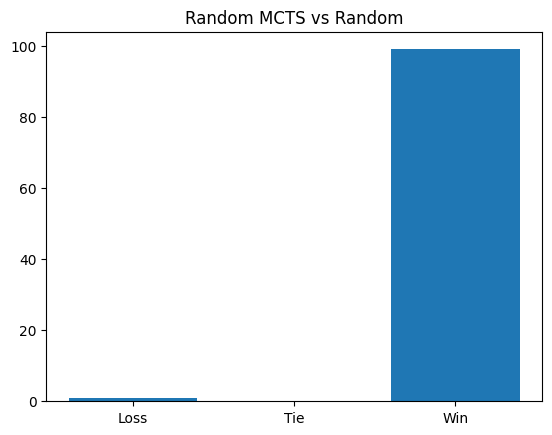

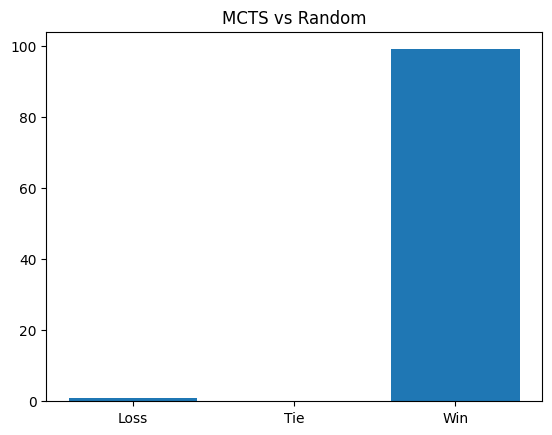

In [267]:
fig, axis = plt.subplots()
match_results = []
for i in range(100):
    match_results.append(play_match(mcts_rand_agent, random_agent))
counts, bins = np.histogram(match_results, bins=3)
axis.bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axis.set_title("Random MCTS vs Random")
fig.show()

fig, axis = plt.subplots()
match_results = []
for i in range(100):
    match_results.append(play_match(mcts_agent, random_agent))
counts, bins = np.histogram(match_results, bins=3)
axis.bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axis.set_title("MCTS vs Random")
fig.show()

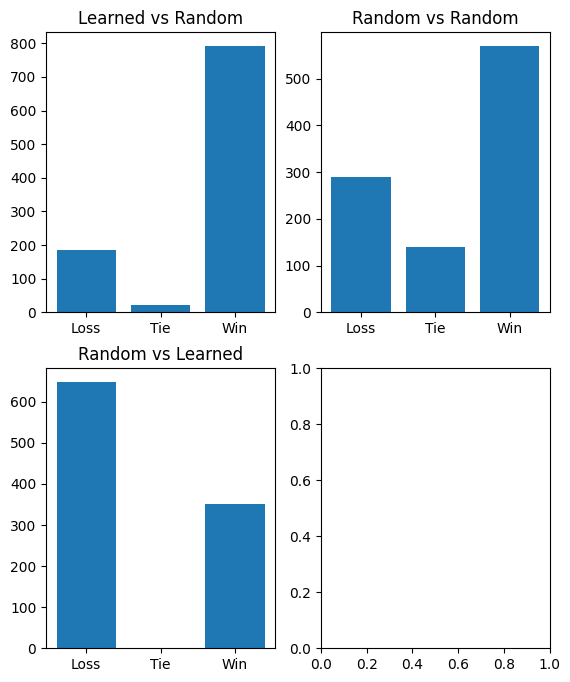

In [263]:
fig, axes = plt.subplots(2, 2, figsize=(6.5,8))

match_results = []
for i in range(1000):
    match_results.append(play_match(learned_agent, random_agent))
counts, bins = np.histogram(match_results, bins=3)
axes[0, 0].bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axes[0, 0].set_title("Learned vs Random")

match_results = []
for i in range(1000):
    match_results.append(play_match(random_agent, random_agent))
counts, bins = np.histogram(match_results, bins=3)
axes[0, 1].bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axes[0, 1].set_title("Random vs Random")

match_results = []
for i in range(1000):
    match_results.append(play_match(random_agent, learned_agent))
counts, bins = np.histogram(match_results, bins=3)
axes[1, 0].bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axes[1, 0].set_title("Random vs Learned")

# match_results = []
# for i in range(1000):
#     match_results.append(play_match(learned_agent, learned_agent))
# counts, bins = np.histogram(match_results, bins=3)
# axes[1, 1].bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
# axes[1, 1].set_title("Learned vs Learned")

fig.show()

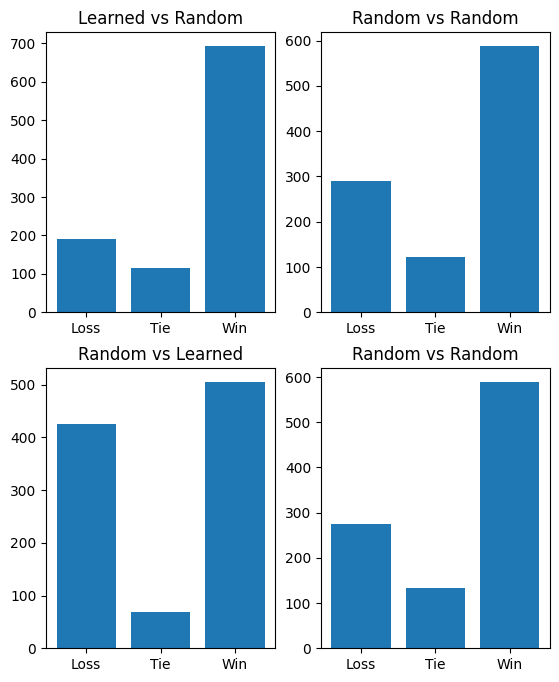

In [182]:
fig, axes = plt.subplots(2, 2, figsize=(6.5,8))

match_results = []
for i in range(1000):
    match_results.append(play_match(learned_agent, random_agent))
counts, bins = np.histogram(match_results, bins=3)
axes[0, 0].bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axes[0, 0].set_title("Learned vs Random")

match_results = []
for i in range(1000):
    match_results.append(play_match(random_agent, random_agent))
counts, bins = np.histogram(match_results, bins=3)
axes[0, 1].bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axes[0, 1].set_title("Random vs Random")

match_results = []
for i in range(1000):
    match_results.append(play_match(random_agent, learned_agent))
counts, bins = np.histogram(match_results, bins=3)
axes[1, 0].bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axes[1, 0].set_title("Random vs Learned")

match_results = []
for i in range(1000):
    match_results.append(play_match(random_agent, random_agent))
counts, bins = np.histogram(match_results, bins=3)
axes[1, 1].bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axes[1, 1].set_title("Random vs Random")

fig.show()

(array([270.,   0.,   0.,   0.,   0., 127.,   0.,   0.,   0., 603.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

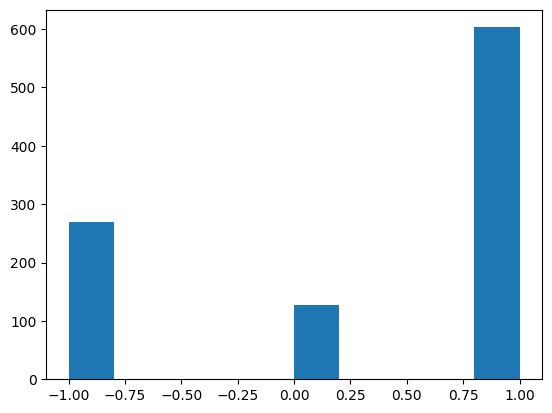

In [128]:
match_results = []
for i in range(1000):
    match_results.append(play_match(random_agent, random_agent))
plt.hist(match_results)